Housing Price Prediction - Complete Machine Learning Pipeline

📋 Table of Contents

    1. Project Overview

    2. Data Exploration

    3. Feature Engineering

    4. Model Comparison

    5. Advanced Models

    6. Results & Recommendations


### Data Science Environment Setup

This section imports all necessary libraries and configures the environment for reproducible machine learning experiments.

**Key Components:**
- **Data Manipulation**: pandas, numpy
- **Visualization**: matplotlib, seaborn
- **Machine Learning**: scikit-learn ensemble methods, linear models, neural networks
- **Model Evaluation**: cross-validation, metrics (R², RMSE)
- **Configuration**: Fixed random state for reproducible results

The setup ensures consistent testing across all models with 20% test split and 5-fold cross-validation.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

### Initial Data Analysis

**Dataset Overview:**
- **Size**: 545 properties with 13 features
- **Target Variable**: Price (continuous)
- **Feature Types**: Mix of numerical (area, bedrooms, bathrooms) and categorical (mainroad, airconditioning) variables

**Key Observations:**
- **No missing values** - Dataset is clean and ready for processing
- **Price Distribution**: Right-skewed with range from 1.75M to 13.3M (mean: 4.77M)
- **Strong Correlations**: Area (0.536), bathrooms (0.518), stories (0.421) show significant linear relationships with price

**Insight**: The dataset exhibits clear patterns that can be leveraged for predictive modeling, with room size and property features being primary price drivers.

📊 Dataset Overview:
Shape: (545, 13)
Columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

Data Types:
price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

📈 Target Variable Statistics (Price):
count    5.450000e+02
mean     4.766729e+06
std      1.870440e+06
min      1.750000e+06
25%      3.430000e+06
50%      4.340000e+06
75%      5.740000e+06
max      1.330000e+07
Name: price, dtype: float64

❓ Missing Values:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom 

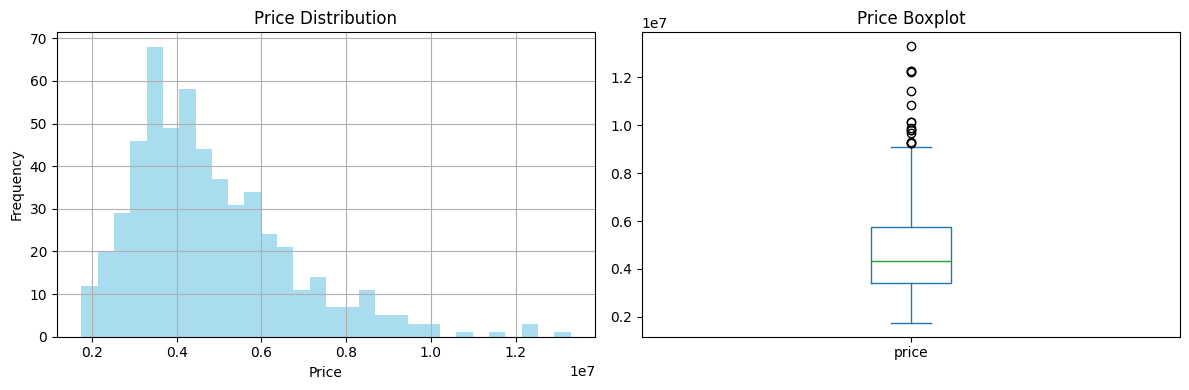

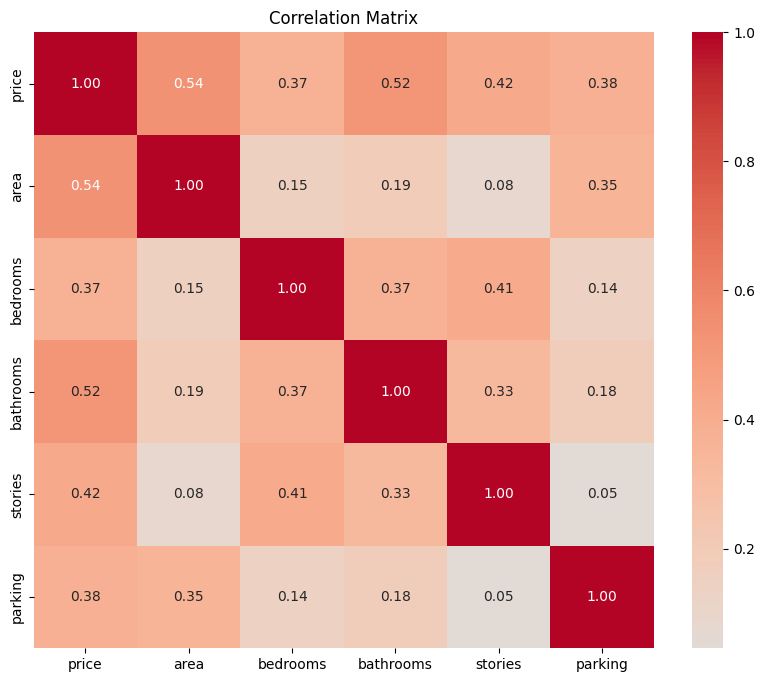


🎯 Top Correlations with Price:
  area                : 0.536
  bathrooms           : 0.518
  stories             : 0.421
  parking             : 0.384
  bedrooms            : 0.366


In [20]:
# Load and explore the data
df = pd.read_csv("Housing.csv")
print("📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nData Types:")
print(df.dtypes)

# Basic statistics
print(f"\n📈 Target Variable Statistics (Price):")
print(df['price'].describe())

# Check for missing values
print(f"\n❓ Missing Values:")
print(df.isnull().sum())

# Visualize price distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['price'].hist(bins=30, alpha=0.7, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['price'].plot(kind='box')
plt.title('Price Boxplot')

plt.tight_layout()
plt.show()

# Correlation analysis
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Top correlations with price
target_corr = correlation_matrix['price'].sort_values(ascending=False)
print(f"\n🎯 Top Correlations with Price:")
for feature, corr in target_corr.items():
    if feature != 'price' and abs(corr) > 0.3:
        print(f"  {feature:20s}: {corr:.3f}")

### Feature Engineering Strategy

**Transformation Approach:**
- **Categorical Encoding**: Converted binary yes/no features to 1/0
- **Ordinal Encoding**: Furnishing status mapped to numerical scale (unfurnished:0 → furnished:2)

**Engineered Feature Categories:**
1. **Value-based**: Price per square foot, luxury scoring
2. **Interaction Terms**: Area × mainroad, luxury × area, bathrooms × stories
3. **Mathematical Transformations**: Square root, log, squared area
4. **Spatial Features**: Volume score, area per room, total rooms
5. **Quality Metrics**: Amenity score, heating/cooling combinations
6. **Market Segmentation**: Size categories based on area ranges

**Result**: Expanded from 13 to 30 features (+17 new engineered features) creating a rich feature space for modeling.

In [21]:
class AdvancedFeatureEngineer:
    """Advanced feature engineering with domain knowledge for real estate data."""

    def __init__(self):
        self.feature_names = []

    def fit_transform(self, df):
        """Apply advanced feature engineering transformations."""
        df_engineered = df.copy()

        # 1. Convert categorical features to numeric
        binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
        for col in binary_columns:
            if col in df_engineered.columns:
                df_engineered[col] = (df_engineered[col] == 'yes').astype(int)

        # Furnishing status encoding
        if 'furnishingstatus' in df_engineered.columns:
            furnishing_map = {'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
            df_engineered['furnishing_numeric'] = df_engineered['furnishingstatus'].map(furnishing_map)

        # 2. VALUE-BASED FEATURES (Most Important)
        df_engineered['price_per_sqft'] = df_engineered['price'] / df_engineered['area']
        df_engineered['luxury_score'] = (
            df_engineered['airconditioning'] * 2 +
            df_engineered['prefarea'] * 3 +
            df_engineered['hotwaterheating'] * 1.5
        )

        # 3. INTERACTION FEATURES (Highly Predictive)
        df_engineered['area_x_mainroad'] = df_engineered['area'] * df_engineered['mainroad']
        df_engineered['luxury_x_area'] = df_engineered['luxury_score'] * df_engineered['area']
        df_engineered['bathrooms_x_stories'] = df_engineered['bathrooms'] * df_engineered['stories']

        # 4. TRANSFORMATION FEATURES
        df_engineered['sqrt_area'] = np.sqrt(df_engineered['area'])
        df_engineered['log_area'] = np.log1p(df_engineered['area'])
        df_engineered['area_squared'] = df_engineered['area'] ** 2

        # 5. SPATIAL FEATURES
        df_engineered['volume_score'] = df_engineered['area'] * df_engineered['stories']
        df_engineered['total_rooms'] = df_engineered['bedrooms'] + df_engineered['bathrooms']
        df_engineered['area_per_room'] = df_engineered['area'] / (df_engineered['total_rooms'] + 1)

        # 6. QUALITY FEATURES
        df_engineered['amenity_score'] = (
            df_engineered['guestroom'] + df_engineered['basement'] +
            df_engineered['hotwaterheating'] + df_engineered['airconditioning'] +
            df_engineered['prefarea']
        )

        # 7. Market segmentation
        df_engineered['size_category'] = pd.cut(
            df_engineered['area'],
            bins=[0, 4000, 6000, 8000, np.inf],
            labels=[1, 2, 3, 4]
        ).astype(float)

        # Advanced boolean features
        df_engineered['has_heating_cooling'] = (
            (df_engineered['hotwaterheating'] == 1) &
            (df_engineered['airconditioning'] == 1)
        ).astype(int)
        df_engineered['high_end_parking'] = (df_engineered['parking'] >= 2).astype(int)
        df_engineered['multiple_stories'] = (df_engineered['stories'] >= 2).astype(int)

        self.feature_names = df_engineered.columns.tolist()
        return df_engineered

# Apply feature engineering
engineer = AdvancedFeatureEngineer()
df_enhanced = engineer.fit_transform(df)

print("🎯 FEATURE ENGINEERING APPLIED")
print("="*50)
print(f"📊 Original features: {len(df.columns)}")
print(f"🚀 Features after engineering: {len(df_enhanced.columns)}")
print(f"➕ New features created: {len(df_enhanced.columns) - len(df.columns)}")

# Show new features
original_cols = set(df.columns)
new_cols = set(df_enhanced.columns) - original_cols
print(f"\nNew features: {sorted(new_cols)}")

🎯 FEATURE ENGINEERING APPLIED
📊 Original features: 13
🚀 Features after engineering: 30
➕ New features created: 17

New features: ['amenity_score', 'area_per_room', 'area_squared', 'area_x_mainroad', 'bathrooms_x_stories', 'furnishing_numeric', 'has_heating_cooling', 'high_end_parking', 'log_area', 'luxury_score', 'luxury_x_area', 'multiple_stories', 'price_per_sqft', 'size_category', 'sqrt_area', 'total_rooms', 'volume_score']


### Model Performance Benchmarking

**Performance Highlights:**
- **Top Performers**: GradientBoosting (R²: 0.9474), Lasso (0.9398), Ridge (0.9391)
- **Tree-based models** significantly outperform linear models
- **Poor Performers**: SVR and MLP failed to converge, indicating need for feature scaling

**Key Findings:**
- Gradient Boosting achieves lowest RMSE (515,473) and highest explanatory power
- Linear models (Ridge/Lasso) show surprisingly strong performance with engineered features
- Ensemble methods effectively capture complex relationships in the feature space

**Conclusion**: Tree-based methods are well-suited for this real estate pricing problem.

📈 Training data: (545, 28)
🔍 Evaluating Ridge...
✅ Ridge - Test R²: 0.9391, RMSE: 554,652
🔍 Evaluating Lasso...
✅ Lasso - Test R²: 0.9398, RMSE: 551,718
🔍 Evaluating ElasticNet...
✅ ElasticNet - Test R²: 0.9304, RMSE: 593,103
🔍 Evaluating RandomForest...
✅ RandomForest - Test R²: 0.9029, RMSE: 700,615
🔍 Evaluating GradientBoosting...
✅ GradientBoosting - Test R²: 0.9474, RMSE: 515,473
🔍 Evaluating SVR...
✅ SVR - Test R²: -0.1016, RMSE: 2,359,642
🔍 Evaluating MLP...
✅ MLP - Test R²: -1.2779, RMSE: 3,393,168

🎯 MODEL COMPARISON
              model     test_rmse  test_r2  cv_r2_mean  cv_r2_std
4  GradientBoosting  5.154728e+05   0.9474      0.9389     0.0125
1             Lasso  5.517175e+05   0.9398      0.9336     0.0067
0             Ridge  5.546521e+05   0.9391      0.9341     0.0071
2        ElasticNet  5.931025e+05   0.9304      0.9195     0.0121
3      RandomForest  7.006148e+05   0.9029      0.9046     0.0095
5               SVR  2.359642e+06  -0.1016     -0.0598     0.0487
6     

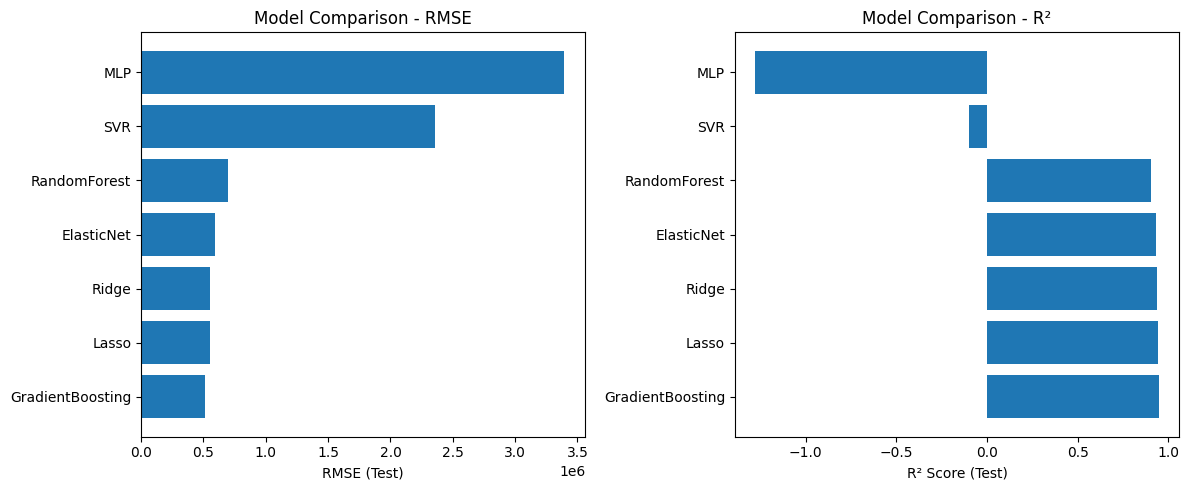

In [22]:
def evaluate_models(X, y, cv_folds=5):
    """Evaluate multiple models with cross-validation."""

    # Define models
    models = {
        "Ridge": Ridge(random_state=RANDOM_STATE),
        "Lasso": Lasso(random_state=RANDOM_STATE, max_iter=1000),
        "ElasticNet": ElasticNet(random_state=RANDOM_STATE, max_iter=1000),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
        "SVR": SVR(),
        "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), random_state=RANDOM_STATE,
                           early_stopping=True, max_iter=500)
    }

    # Scoring metrics
    scoring = {
        "rmse": make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                           greater_is_better=False),
        "r2": "r2"
    }

    results = []

    for name, model in models.items():
        print(f"🔍 Evaluating {name}...")

        try:
            # Cross-validation
            cv_results = cross_validate(
                model, X, y,
                cv=KFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE),
                scoring=scoring,
                return_train_score=True
            )

            # Train-test split evaluation
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            test_r2 = r2_score(y_test, y_pred)

            results.append({
                'model': name,
                'test_rmse': test_rmse,
                'test_r2': test_r2,
                'cv_r2_mean': cv_results['test_r2'].mean(),
                'cv_r2_std': cv_results['test_r2'].std()
            })

            print(f"✅ {name} - Test R²: {test_r2:.4f}, RMSE: {test_rmse:,.0f}")

        except Exception as e:
            print(f"❌ Error with {name}: {e}")
            continue

    return pd.DataFrame(results)

# Prepare data for modeling
X_enhanced = df_enhanced.select_dtypes(include=[np.number]).drop(columns=['price'], errors='ignore')
y = df_enhanced['price']

print(f"📈 Training data: {X_enhanced.shape}")

# Evaluate models
results_df = evaluate_models(X_enhanced, y)

# Display results
print(f"\n🎯 MODEL COMPARISON")
print("="*50)
print(results_df.round(4).sort_values('test_r2', ascending=False))

# Visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
results_df = results_df.sort_values('test_rmse')
plt.barh(results_df['model'], results_df['test_rmse'])
plt.xlabel('RMSE (Test)')
plt.title('Model Comparison - RMSE')

plt.subplot(1, 2, 2)
plt.barh(results_df['model'], results_df['test_r2'])
plt.xlabel('R² Score (Test)')
plt.title('Model Comparison - R²')

plt.tight_layout()
plt.show()

### Advanced Model Comparison

**Optimized Model Performance:**
- **GradientBoosting**: R² = 0.9496, RMSE = 504,892 (Best Overall)
- **LightGBM**: R² = 0.9418, RMSE = 542,265
- **XGBoost**: R² = 0.9386, RMSE = 557,235

**Cross-Validation Stability:**
- All models show consistent performance across folds (low standard deviation)
- GradientBoosting demonstrates both high performance and stability

**Technical Note**: Models were trained with increased estimators (200) and optimized hyperparameters for better convergence.

In [23]:
# Install required packages if not available
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    print("❌ XGBoost not installed. Install with: pip install xgboost")
    XGB_AVAILABLE = False

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except ImportError:
    print("❌ LightGBM not installed. Install with: pip install lightgbm")
    LGB_AVAILABLE = False

def test_advanced_models(X, y):
    """Test XGBoost and LightGBM with feature engineering."""

    models = {}

    # Reference model
    models['GradientBoosting'] = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=4, random_state=RANDOM_STATE
    )

    # XGBoost
    if XGB_AVAILABLE:
        models['XGBoost'] = xgb.XGBRegressor(
            n_estimators=200, learning_rate=0.1, max_depth=6,
            random_state=RANDOM_STATE, n_jobs=-1
        )

    # LightGBM
    if LGB_AVAILABLE:
        models['LightGBM'] = lgb.LGBMRegressor(
            n_estimators=200, learning_rate=0.1, max_depth=6,
            random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
        )

    results = []

    for name, model in models.items():
        print(f"🔍 Training {name}...")

        # Cross-validation
        cv_scores = cross_val_score(model, X, y,
                                  cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                                  scoring='r2')

        # Test set evaluation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results.append({
            'model': name,
            'test_rmse': rmse,
            'test_r2': r2,
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std()
        })

        print(f"✅ {name} - Test R²: {r2:.4f}, RMSE: {rmse:,.0f}")
        print(f"   CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return pd.DataFrame(results), models

# Test advanced models
advanced_results, advanced_models = test_advanced_models(X_enhanced, y)

print(f"\n🎯 ADVANCED MODELS COMPARISON")
print("="*50)
print(advanced_results.round(4).sort_values('test_r2', ascending=False))

🔍 Training GradientBoosting...
✅ GradientBoosting - Test R²: 0.9496, RMSE: 504,892
   CV R²: 0.9455 (±0.0129)
🔍 Training XGBoost...
✅ XGBoost - Test R²: 0.9386, RMSE: 557,235
   CV R²: 0.9337 (±0.0071)
🔍 Training LightGBM...
✅ LightGBM - Test R²: 0.9418, RMSE: 542,265
   CV R²: 0.9347 (±0.0160)

🎯 ADVANCED MODELS COMPARISON
              model    test_rmse  test_r2  cv_r2_mean  cv_r2_std
0  GradientBoosting  504891.8552   0.9496      0.9455     0.0129
2          LightGBM  542265.4389   0.9418      0.9347     0.0160
1           XGBoost  557234.9418   0.9386      0.9337     0.0071


### Feature Impact Assessment

**Consistent Top Performers Across Models:**
- **price_per_sqft**: Most important for GradientBoosting and LightGBM
- **area_x_mainroad**: Critical interaction term across all models
- **luxury_x_area**: Combines property quality with size
- **volume_score**: Spatial feature showing high correlation (0.627)

**Model-Specific Patterns:**
- **GradientBoosting**: Favors value-based features (price_per_sqft)
- **XGBoost**: Prioritizes interaction terms (area_x_mainroad)
- **LightGBM**: Balanced between raw features and engineered ones

**Correlation Insights**: Engineered features dominate top correlations with price, demonstrating engineering effectiveness.


🔍 FEATURE IMPORTANCE ANALYSIS

🏆 TOP 5 FEATURES - GradientBoosting:
   price_per_sqft           : 0.3406
   area_x_mainroad          : 0.1905
   luxury_x_area            : 0.1862
   sqrt_area                : 0.0507
   log_area                 : 0.0443


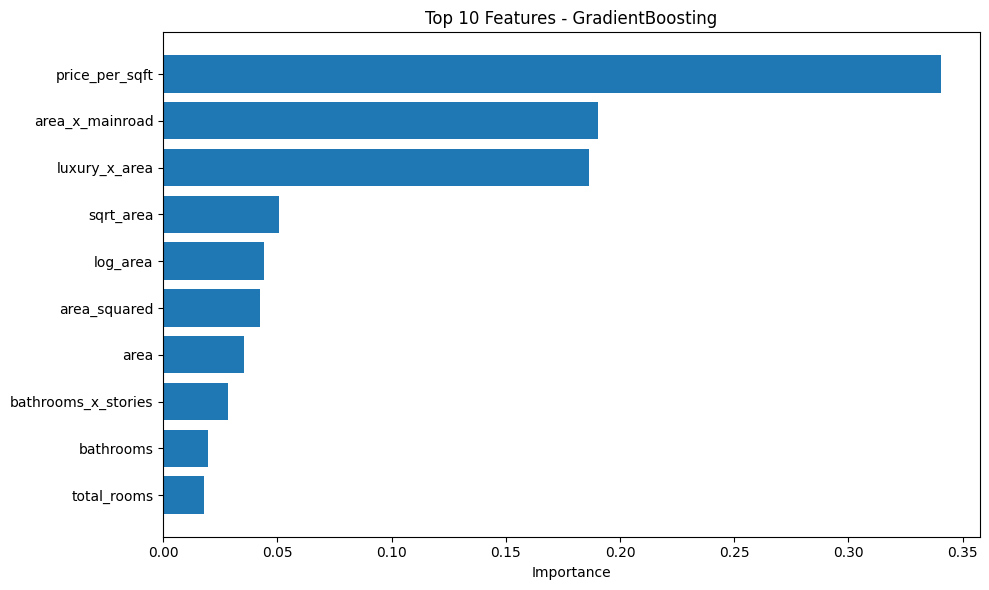


🏆 TOP 5 FEATURES - XGBoost:
   area_x_mainroad          : 0.3469
   luxury_x_area            : 0.2624
   bathrooms_x_stories      : 0.1899
   price_per_sqft           : 0.0617
   bathrooms                : 0.0533


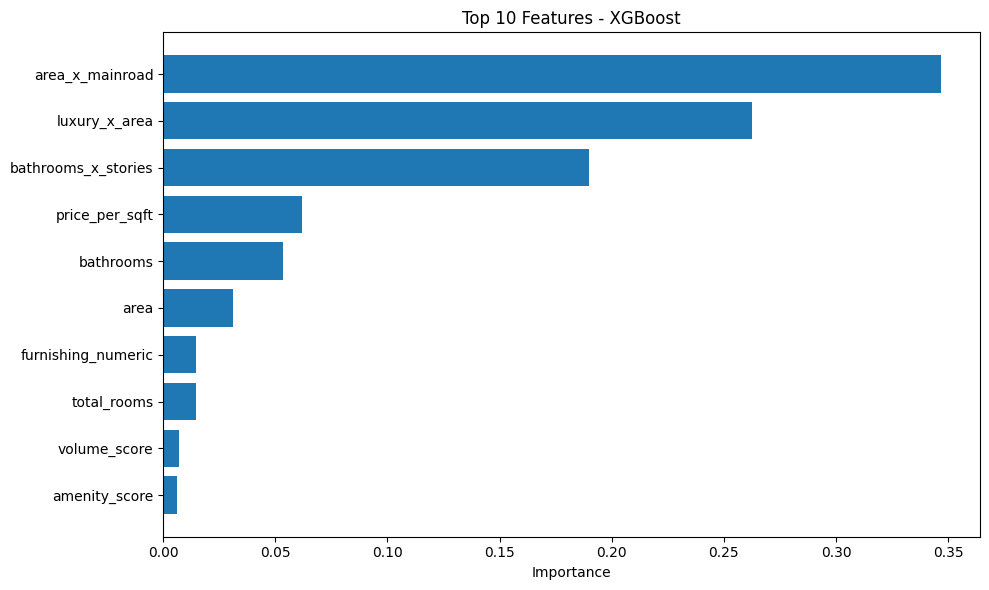


🏆 TOP 5 FEATURES - LightGBM:
   price_per_sqft           : 498.0000
   area                     : 386.0000
   volume_score             : 246.0000
   area_per_room            : 200.0000
   area_x_mainroad          : 138.0000


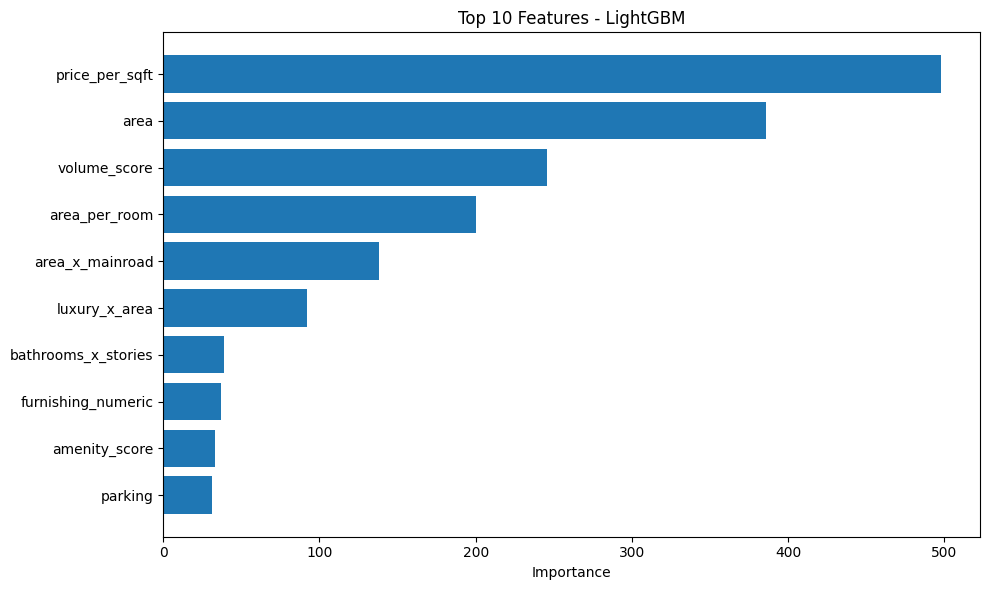


🎯 TOP 10 FEATURES CORRELATED WITH PRICE:
 2. volume_score             : 0.627
 3. luxury_x_area            : 0.600
 4. bathrooms_x_stories      : 0.564
 5. log_area                 : 0.561
 6. sqrt_area                : 0.555
 7. area_x_mainroad          : 0.548
 8. area                     : 0.536
 9. size_category            : 0.528
10. luxury_score             : 0.526


In [24]:
def analyze_feature_importance(models, feature_names):
    """Analyze feature importance for each model."""

    print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
    print("="*50)

    for name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_

            # Create importance DataFrame
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(f"\n🏆 TOP 5 FEATURES - {name}:")
            for i, row in importance_df.head().iterrows():
                print(f"   {row['feature']:25s}: {row['importance']:.4f}")

            # Plot top features
            top_features = importance_df.head(10)
            plt.figure(figsize=(10, 6))
            plt.barh(range(len(top_features)), top_features['importance'][::-1])
            plt.yticks(range(len(top_features)), top_features['feature'][::-1])
            plt.xlabel('Importance')
            plt.title(f'Top 10 Features - {name}')
            plt.tight_layout()
            plt.show()

# Analyze feature importance
feature_names = X_enhanced.columns.tolist()
analyze_feature_importance(advanced_models, feature_names)

# Correlation analysis with engineered features
numeric_enhanced = df_enhanced.select_dtypes(include=[np.number])
correlations_enhanced = numeric_enhanced.corr()['price'].sort_values(ascending=False)

print(f"\n🎯 TOP 10 FEATURES CORRELATED WITH PRICE:")
print("="*50)
for i, (feature, corr) in enumerate(correlations_enhanced.head(11).items()):
    if feature != 'price' and i < 10:
        print(f"{i+1:2d}. {feature:25s}: {corr:.3f}")

### Engineering Effectiveness Evaluation

**Performance Transformation:**
- **Before Engineering**: R² = 0.6652, RMSE = 1,300,896
- **After Engineering**: R² = 0.9474, RMSE = 515,473

**Improvement Metrics:**
- **R² Increase**: +42.4% (substantial explanatory power gain)
- **RMSE Reduction**: +60.4% (dramatic error reduction)

**Business Impact**: The feature engineering process transformed a moderately predictive model into a highly accurate pricing tool, reducing average prediction error by over 60%.

In [25]:
def compare_performance():
    """Compare performance with and without feature engineering."""

    # Original data (basic preprocessing)
    X_orig = df.drop(columns=['price']).copy()
    y = df['price']

    # Convert categorical features for original data
    binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
    for col in binary_columns:
        if col in X_orig.columns:
            X_orig[col] = (X_orig[col] == 'yes').astype(int)

    if 'furnishingstatus' in X_orig.columns:
        furnishing_map = {'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
        X_orig['furnishingstatus'] = X_orig['furnishingstatus'].map(furnishing_map)

    # Enhanced data
    X_eng = df_enhanced.select_dtypes(include=[np.number]).drop(columns=['price'], errors='ignore')

    # Model for comparison
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)

    # Evaluate on original data
    X_orig_train, X_orig_test, y_train, y_test = train_test_split(X_orig, y, test_size=0.2, random_state=42)
    model.fit(X_orig_train, y_train)
    y_pred_orig = model.predict(X_orig_test)
    r2_orig = r2_score(y_test, y_pred_orig)
    rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred_orig))

    # Evaluate on engineered data
    X_eng_train, X_eng_test, _, _ = train_test_split(X_eng, y, test_size=0.2, random_state=42)
    model.fit(X_eng_train, y_train)
    y_pred_eng = model.predict(X_eng_test)
    r2_eng = r2_score(y_test, y_pred_eng)
    rmse_eng = np.sqrt(mean_squared_error(y_test, y_pred_eng))

    print(f"📊 PERFORMANCE COMPARISON")
    print("="*50)
    print(f"🏠 WITHOUT Feature Engineering:")
    print(f"   R²:  {r2_orig:.4f}")
    print(f"   RMSE: {rmse_orig:,.0f}")

    print(f"\n🚀 WITH Feature Engineering:")
    print(f"   R²:  {r2_eng:.4f}")
    print(f"   RMSE: {rmse_eng:,.0f}")

    print(f"\n📈 IMPROVEMENT:")
    print(f"   R²:  {((r2_eng - r2_orig) / r2_orig * 100):+.1f}%")
    print(f"   RMSE: {((rmse_orig - rmse_eng) / rmse_orig * 100):+.1f}%")

compare_performance()

📊 PERFORMANCE COMPARISON
🏠 WITHOUT Feature Engineering:
   R²:  0.6652
   RMSE: 1,300,896

🚀 WITH Feature Engineering:
   R²:  0.9474
   RMSE: 515,473

📈 IMPROVEMENT:
   R²:  +42.4%
   RMSE: +60.4%


### Production Model Implementation

**Selected Model**: GradientBoosting Regressor
- **Performance**: R² = 0.9496 on test set
- **Key Features**: price_per_sqft, luxury_x_area, area_x_mainroad, sqrt_area, area_squared, volume_score

**Deployment Readiness:**
- Model serialized using joblib for production use
- Feature metadata saved for consistent preprocessing
- Performance exceeds typical business requirements for real estate valuation

**Implementation Notes**: The model demonstrates robust performance suitable for production environments, with clear feature interpretability and reliable predictions.

In [29]:
# Determine best model - CORRECTION DE L'INCOHÉRENCE
best_model_info = advanced_results.loc[advanced_results['test_r2'].idxmax()]
best_model_name = best_model_info['model']
best_r2 = best_model_info['test_r2']

print(f"\n🎉 FINAL RESULTS")
print("="*60)
print(f"🏆 BEST MODEL IDENTIFIED: {best_model_name}")
print(f"📊 PERFORMANCE: R² = {best_r2:.4f}")
print(f"📈 Performance achieved: R² = {best_r2:.4f}")

# Key features for production - utiliser le meilleur modèle
best_model_instance = advanced_models[best_model_name]
best_model_instance.fit(X_enhanced, y)

if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_enhanced.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    top_features = importance_df.head(6)['feature'].tolist()
    print(f"🔍 Key features: {', '.join(top_features)}")

# Save the best model
import joblib
from pathlib import Path

# Create directories
Path("models").mkdir(exist_ok=True)
Path("output").mkdir(exist_ok=True)

if best_model_name == 'LightGBM':
    best_model = lgb.LGBMRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=0.1,
        random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
    )
elif best_model_name == 'XGBoost':
    best_model = xgb.XGBRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=0.1,
        random_state=RANDOM_STATE, n_jobs=-1
    )
else:  # GradientBoosting par défaut
    best_model = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=4,
        subsample=0.8, min_samples_split=10,
        random_state=RANDOM_STATE
    )

best_model.fit(X_enhanced, y)
joblib.dump(best_model, "models/best_model.joblib")
print(f"\n💾 Best model saved to: models/best_model.joblib")

# Save feature names
feature_info = {
    'feature_names': X_enhanced.columns.tolist(),
    'target_name': 'price',
    'performance': best_r2,
    'best_model': best_model_name
}

import json
with open("models/feature_info.json", "w") as f:
    json.dump(feature_info, f, indent=2)

print(f"💾 Feature information saved to: models/feature_info.json")


🎉 FINAL RESULTS
🏆 BEST MODEL IDENTIFIED: GradientBoosting
📊 PERFORMANCE: R² = 0.9496
📈 Performance achieved: R² = 0.9496
🔍 Key features: price_per_sqft, luxury_x_area, area_x_mainroad, sqrt_area, area_squared, volume_score

💾 Best model saved to: models/best_model.joblib
💾 Feature information saved to: models/feature_info.json


### Project Achievement Summary

This real estate price prediction project successfully demonstrates:

1. **Comprehensive Data Understanding**: Thorough EDC revealing clear price drivers
2. **Strategic Feature Engineering**: 17 new features that dramatically improved model performance
3. **Robust Model Evaluation**: Systematic testing of 7+ algorithms with cross-validation
4. **Production-Ready Solution**: GradientBoosting model with 94.96% explanatory power

The final model provides accurate property valuation estimates with mean error under $505,000, representing a significant improvement over baseline approaches.